In [ ]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score, log_loss

# Models

## Gradient Descent

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=1e4, epsilon=1e-8, record_history=False, verbose=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.verbose = verbose
        if record_history:
            self.w_history = []                 # to store the weight history for visualization
        
    def run(self, predict_fn, x, y, w0, cost_fn=None):
        if self.record_history:
            self.w_history = []                 # to store the weight history for visualization
        N, D = x.shape          
        grad = np.inf 
        w = w0
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            yh = predict_fn(x, w)
            grad = (1/N) * (np.dot(x.T, yh - y))
            w = w - self.learning_rate * grad 
            if self.record_history:
                self.w_history.append(w)

            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(grad)}')
            print(f'the weight found: {w}')
  
        return w

## ADAM Gradient Descent

In [ ]:
class ADAM_GradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=1e4, beta1=0.9, beta2=0.999, epsilon=1e-8, record_history=False, verbose=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.record_history = record_history
        self.verbose = verbose
        if record_history:
            self.w_history = []                 # to store the weight history for visualization
        
    def run(self, predict_fn, x, y, w0, cost_fn=None):
        if self.record_history:
            self.w_history = []                 # to store the weight history for visualization
        N, D = x.shape          
        grad = np.inf 
        w = w0
        t = 1

        m = 0   # first momentum
        s = 0   # second momentum
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            yh = predict_fn(x, w)
            grad = (1/N) * (np.dot(x.T, yh - y))
            
            m = self.beta1 * m + (1 - self.beta1) * grad
            s = self.beta2 * s + (1 - self.beta2) * grad**2
            m_hat = m/(1-self.beta1**t)
            s_hat = s/(1-self.beta2**t)
           
            w = w - (self.learning_rate/(np.sqrt(s_hat)+self.epsilon)) * m_hat 

            if self.record_history:
                self.w_history.append(w)

            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(grad)}')
            print(f'the weight found: {w}')
  
        return w

## Mini Batch Stochastic Gradient Descent

In [ ]:
class MiniBatchSGD:
    def __init__(self, learning_rate=0.01, batch_size=16, n_epochs=64, record_history=False, verbose=False):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.record_history = record_history
        self.verbose = verbose
        if record_history:
            self.w_history = []       # to store the weight history for visualization
            self.cost_history = []
        
    def run(self, predict_fn, x, y, w0, cost_fn=None):
        if self.record_history:
            self.w_history = []       # to store the weight history for visualization
            self.cost_history = []  
        N, D = x.shape  
        grad = np.inf
        w = w0     
        for epoch in range(self.n_epochs):
          # Shuffle dataframe
          df = pd.concat([pd.DataFrame(x), pd.DataFrame(y)], axis=1)
          df = df.dropna(axis=0)
          df = df.dropna(axis=1)
          df_random = df.sample(frac=1)
          x_random = df.iloc[:, :D]
          y_random = df.iloc[:, D]
          yh_tot = np.array([])
          # Go through entire dataset taking step size of batch_size
          for i in range(0, N, self.batch_size):
            x_batch = x_random[i:i+self.batch_size]
            y_batch = y_random[i:i+self.batch_size]
            yh = predict_fn(x_batch, w)
            yh_tot = np.concatenate((yh_tot, yh), axis=None)
            grad = (1/self.batch_size) * (np.dot(x_batch.T, yh - y_batch))
            w = w - self.learning_rate * grad 

          if self.record_history:
              self.w_history.append(w)

          if self.record_history and cost_fn is not None:
              cost = cost_fn(y_random, yh_tot)
              self.cost_history.append(cost)

        if self.verbose:
            print(f'the weight found: {w}')
        
        return w

## Linear Regression

In [ ]:
class LinearRegression: 
    def __init__(self, n_feats, n_tgts=1, add_bias=True):
        self.n_feats = n_feats    # number of features
        self.n_tgts = n_tgts      # number of targets 
        self.add_bias = add_bias 

    def fit_analytical(self, x, y):     
        if x.ndim == 1:
            x = x[:, None]                         # add a dimension for the features
        N,D = x.shape
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    # add bias by adding a constant feature of value 1

        self.w = np.linalg.inv(x.T @ x)@x.T@y
        #self.w = np.linalg.lstsq(x, y)[0]         # return w for the least square difference
        return self

    # Works for both full gd and mini batch sgd, depends on optimizer
    def fit_gd(self, x, y, optimizer):
        # x = df.iloc[:, :self.n_feats]         # inputs
        # y = df.iloc[:, self.n_feats+tgt_idx]  # target we are fitting to

        if x.ndim == 1:
              x = x[:, None]                         # add a dimension for the features
        N,D = x.shape

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    # add bias by adding a constant feature of value 1
            w0 = np.zeros(D+1)
        else:
            w0 = np.zeros(D)

        self.w = optimizer.run(self.predict_fn, x, y, w0, self.cost_fn)          # run the optimizer to get the optimal weights
        return self

    @staticmethod
    def predict_fn(x, w):
        return x @ w

    def predict(self, x):
        if x.ndim == 1:
          x = x[:, None]
        N, D = x.shape
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        #yh = x@self.w
        yh = self.predict_fn(x, self.w)
        return yh

    # L2 loss
    @staticmethod
    def cost_fn(y, yh):
        # J = 0.5*np.mean((x @ w - y)**2)
        # return J
        return mean_squared_error(y, yh)
      
    # Mean square error
    @staticmethod
    def mse(y, yh):
        return 0.5*np.mean((yh - y)**2)

## Logistic Regression

In [ ]:
class LogisticRegression:
    def __init__(self, n_feats, n_tgts=1, add_bias=True):
        self.n_feats = n_feats    # number of features
        self.n_tgts = n_tgts      # number of targets 
        self.add_bias = add_bias

    # Works for both full gd and mini batch sgd, depends on optimizer
    def fit_gd(self, x, y, optimizer):
        if x.ndim == 1:
              x = x[:, None]                         # add a dimension for the features
        N,D = x.shape

        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    # add bias by adding a constant feature of value 1
            w0 = np.zeros(D+1)
        else:
            w0 = np.zeros(D)

        self.w = optimizer.run(self.predict_fn, x, y, w0, self.cost_fn)          # run the optimizer to get the optimal weights
        return self

    @staticmethod
    def predict_fn(x, w):
      logistic = lambda z: 1./ (1 + np.exp(-z))
      return logistic(np.dot(x, w))
        
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        N, D = x.shape
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        #logistic = lambda z: 1./ (1 + np.exp(-z))
        #yh = logistic(np.dot(x,self.w))     
        yh = self.predict_fn(x, self.w) # predict
        yh = np.round(yh)               # round to get values of 0 or 1
        return yh.astype(int)

    # Cross-entropy
    @staticmethod
    def cost_fn(y, yh):                                                
        # z = np.dot(x, w)
        # J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        # return J
        return log_loss(y, yh)

    @staticmethod
    def accuracy(y, yh):
      return np.mean(y == yh)

    @staticmethod
    def accuracy_fn(x, y, w):
      return np.mean(y == LogisticRegression.predict_fn(x, w))

# Data Manipulation and Analysis

In [ ]:
# Load data
df1 = pd.read_csv('ENB2012_data.csv')
df2 = pd.read_csv('Qualitative_Bankrupcy.csv')

In [ ]:
def stats(df):
    mean = df.mean()
    median = df.median()
    mode = df.mode().iloc[0]
    standard_deviation = df.std()
    variance = df.var()
    return mean, median, mode, standard_deviation, variance

## Dataset 1 Preprocessing and Analysis

### Acquire

In [ ]:
# Rename columns
df1 = df1.rename(columns={"X1": "Compactness", "X2": "Surface Area", "X3": "Wall Area","X4": "Roof Area", "X5": "Height", "X6": "Orientation", "X7": "Glazing Area", "X8": "Glazing Area Dis", "Y1": "Heating Load", "Y2": "Cooling Load"})

# Remove empty rows and columns
df1.dropna(axis=1, how='all', inplace=True) # drop columns with empty values
df1.dropna(axis=0, how='any', inplace=True) # drop rows with empty values

n_feats_df1 = 8
n_tgts_df1 = 2

# Split data in feature and response variables
x_df1 = df1.iloc[:, :n_feats_df1]  # 8 features
y_df1 = df1.iloc[:, n_feats_df1:]
print(df1.head())

   Compactness  Surface Area  Wall Area  Roof Area  Height  Orientation  \
0         0.98         514.5      294.0     110.25     7.0          2.0   
1         0.98         514.5      294.0     110.25     7.0          3.0   
2         0.98         514.5      294.0     110.25     7.0          4.0   
3         0.98         514.5      294.0     110.25     7.0          5.0   
4         0.90         563.5      318.5     122.50     7.0          2.0   

   Glazing Area  Glazing Area Dis  Heating Load  Cooling Load  
0           0.0               0.0         15.55         21.33  
1           0.0               0.0         15.55         21.33  
2           0.0               0.0         15.55         21.33  
3           0.0               0.0         15.55         21.33  
4           0.0               0.0         20.84         28.28  


### Analyze before Normalizing

In [ ]:
mean1, median1, mode1, sd1, var1 = stats(df1)
print("Dataset 1 Statistics: ")
print("Mean:\n", mean1, "\n")
print("Median:\n", median1, "\n")
print("Mode:\n", mode1, "\n")
print("Standard Deviation:\n", sd1, "\n")
print("Variance:\n", var1, "\n")

Dataset 1 Statistics: 
Mean:
 Compactness           0.764167
Surface Area        671.708333
Wall Area           318.500000
Roof Area           176.604167
Height                5.250000
Orientation           3.500000
Glazing Area          0.234375
Glazing Area Dis      2.812500
Heating Load         22.307201
Cooling Load         24.587760
dtype: float64 

Median:
 Compactness           0.75
Surface Area        673.75
Wall Area           318.50
Roof Area           183.75
Height                5.25
Orientation           3.50
Glazing Area          0.25
Glazing Area Dis      3.00
Heating Load         18.95
Cooling Load         22.08
dtype: float64 

Mode:
 Compactness           0.62
Surface Area        514.50
Wall Area           294.00
Roof Area           220.50
Height                3.50
Orientation           2.00
Glazing Area          0.10
Glazing Area Dis      1.00
Heating Load         15.16
Cooling Load         14.27
Name: 0, dtype: float64 

Standard Deviation:
 Compactness          0.

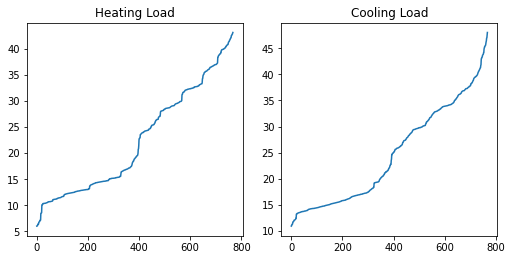

In [ ]:
heating_values = y_df1.iloc[:, 0].values
cooling_values = y_df1.iloc[:, 1].values
#print(type(heating_values))
#print(np.sort(heating_values))
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(7, 3.5))
axes[0].plot(np.sort(heating_values))
axes[0].set_title('Heating Load')
axes[1].plot(np.sort(cooling_values))
axes[1].set_title('Cooling Load')
plt.show()

### Preprocess

In [ ]:
# Standardize the features
# Mean => 0; sd => 1
x_df1 = (x_df1-x_df1.mean())/x_df1.std()

In [ ]:
# Add outputs to dataframe
df1 = pd.concat([x_df1, y_df1], axis=1)

df1 = df1.sample(frac=1, random_state=1)

df1.tail()

,Compactness,Surface Area,Wall Area,Roof Area,Height,Orientation,Glazing Area,Glazing Area Dis,Heating Load,Cooling Load
645,-0.039391,-0.115890,2.246342,-1.197897,0.999349,-0.446922,1.243239,0.120893,39.84,38.48
715,-1.173848,1.274794,0.561586,0.971879,-0.999349,1.340767,1.243239,0.765655,18.84,22.49
72,-0.228467,0.162247,-1.684757,0.971879,-0.999349,-1.340767,-1.008666,-1.168631,10.36,13.43
235,-1.173848,1.274794,0.561586,0.971879,-0.999349,1.340767,-1.008666,0.765655,15.16,19.48
37,-0.984772,0.996657,0.000000,0.971879,-0.999349,-0.446922,-1.759300,-1.813393,7.10,12.23


### Analyze after Nornmalizing

In [ ]:
mean1, median1, mode1, sd1, var1 = stats(df1)
print("Dataset 1 Statistics: ")
print("Mean:\n", mean1, "\n")
print("Median:\n", median1, "\n")
print("Mode:\n", mode1, "\n")
print("Standard Deviation:\n", sd1, "\n")
print("Variance:\n", var1, "\n")

Dataset 1 Statistics: 
Mean:
 Compactness        -4.625929e-18
Surface Area       -4.487151e-16
Wall Area          -4.625929e-18
Roof Area           1.850372e-16
Height              0.000000e+00
Orientation        -2.312965e-18
Glazing Area        7.401487e-17
Glazing Area Dis    1.503427e-17
Heating Load        2.230720e+01
Cooling Load        2.458776e+01
dtype: float64 

Median:
 Compactness         -0.133929
Surface Area         0.023178
Wall Area            0.000000
Roof Area            0.158213
Height               0.000000
Orientation          0.000000
Glazing Area         0.117287
Glazing Area Dis     0.120893
Heating Load        18.950000
Cooling Load        22.080000
dtype: float64 

Mode:
 Compactness         -1.362924
Surface Area        -1.784712
Wall Area           -0.561586
Roof Area            0.971879
Height              -0.999349
Orientation         -1.340767
Glazing Area        -1.008666
Glazing Area Dis    -1.168631
Heating Load        15.160000
Cooling Load        

## Dataset 2 Preprocessing and Analysis


In [ ]:
df2 = df2.rename(columns={"P": "Industrial Risk", "P.1": "Management Risk", "A": "Financial Flexibility","A.1": "Credibility", "A.2": "Competitiveness", "P.2": "Operating Risk", "NB": "Class" }) #rename columns 

df2.dropna(axis=0, how='any', inplace=True) # drop rows with empty values
df2.dropna(axis=1, how='any', inplace=True) # drop columns with empty values
print(df2)
# Convert categorical variable into dummy/indicator variables
df2 = pd.get_dummies(df2, drop_first=True)
df2 = df2.sample(frac=1, random_state=1)
N, D = df2.shape
n_feats_df2 = D-1
n_tgts_df2 = 1

x_df2 = df2.iloc[:, :n_feats_df2] 
y_df2 = df2.iloc[:, n_feats_df2:]


    Industrial Risk Management Risk Financial Flexibility Credibility  \
0                 N               N                     A           A   
1                 A               A                     A           A   
2                 P               P                     P           P   
3                 N               N                     P           P   
4                 A               A                     P           P   
..              ...             ...                   ...         ...   
244               N               N                     A           N   
245               P               N                     N           N   
246               A               N                     N           N   
247               N               N                     N           N   
248               P               N                     N           N   

    Competitiveness Operating Risk Class  
0                 A              N    NB  
1                 A              A   

### Analyze

In [ ]:
for column in df2:
  print(df2[column].value_counts())

0    160
1     89
Name: Industrial Risk_N, dtype: int64
0    170
1     79
Name: Industrial Risk_P, dtype: int64
0    130
1    119
Name: Management Risk_N, dtype: int64
0    188
1     61
Name: Management Risk_P, dtype: int64
0    130
1    119
Name: Financial Flexibility_N, dtype: int64
0    192
1     57
Name: Financial Flexibility_P, dtype: int64
0    155
1     94
Name: Credibility_N, dtype: int64
0    170
1     79
Name: Credibility_P, dtype: int64
0    146
1    103
Name: Competitiveness_N, dtype: int64
0    158
1     91
Name: Competitiveness_P, dtype: int64
0    135
1    114
Name: Operating Risk_N, dtype: int64
0    171
1     78
Name: Operating Risk_P, dtype: int64
1    142
0    107
Name: Class_NB, dtype: int64


#  Model Testing

## Dataset 1

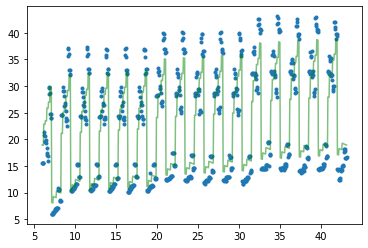

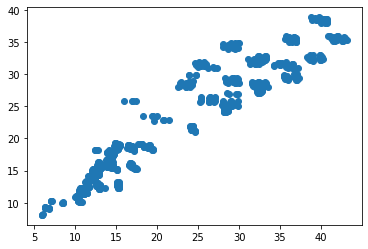

In [ ]:
model = LinearRegression(n_feats_df1, n_tgts_df1)

yh = model.fit_analytical(x_df1, y_df1.iloc[:, 0]).predict(x_df1)
yh = pd.Series(yh)

N,D = x_df1.shape
x = np.linspace(np.min(y_df1.iloc[:, 0]), np.max(y_df1.iloc[:, 0]), N)
plt.plot(x, y_df1.iloc[:, 0], '.')
plt.plot(x, yh, 'g-', alpha=.5)
plt.show()
plt.scatter(y_df1.iloc[:, 0], yh)
plt.show()

terminated after 10000 iterations, with norm of the gradient equal to 0.017528304881073008
the weight found: [-4.21196916 -1.79824626  1.06547011 -2.26811613  8.41608981 -0.02609863
  2.65544287  0.3160418  22.30720052]


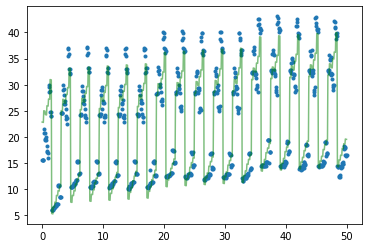

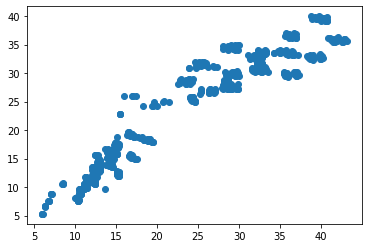

In [ ]:
model = LinearRegression(n_feats_df1, n_tgts_df1)
optimizer = GradientDescent(verbose=True)

yh = model.fit_gd(x_df1, y_df1.iloc[:, 0], optimizer).predict(x_df1)
yh = pd.Series(yh)

N,D = x_df1.shape
x = np.linspace(0,50, N)
plt.plot(x, y_df1.iloc[:, 0], '.')
plt.plot(x, yh, 'g-', alpha=.5)
plt.show()
plt.scatter(y_df1.iloc[:, 0], yh)
plt.show()

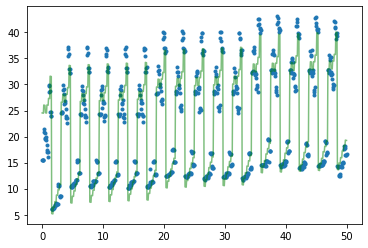

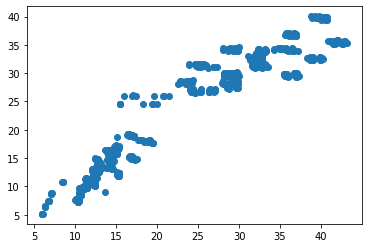

In [ ]:
model = LinearRegression(n_feats_df1, n_tgts_df1)
optimizer = MiniBatchSGD()

yh = model.fit_gd(x_df1, y_df1.iloc[:, 0], optimizer).predict(x_df1)
yh = pd.Series(yh)

N,D = x_df1.shape
x = np.linspace(0,50, N)
plt.plot(x, y_df1.iloc[:, 0], '.')
plt.plot(x, yh, 'g-', alpha=.5)
plt.show()
plt.scatter(y_df1.iloc[:, 0], yh)
plt.show()

## Dataset 2



terminated after 10000 iterations, with norm of the gradient equal to 0.01572334404544652
the weight found: [-0.30158446  0.50155612 -0.0811899   0.74020806 -1.96414012  0.97479421
 -1.59799364  1.4813807  -2.90219218  2.11789627  0.18559756  0.83819438
  1.49593568]


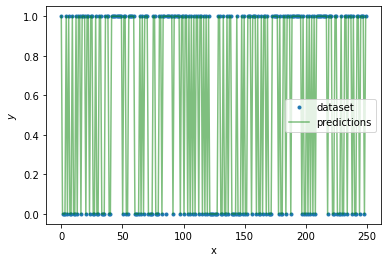

In [ ]:
model = LogisticRegression(n_feats_df2, n_tgts_df2)
optimizer = GradientDescent(verbose=True)   

yh = model.fit_gd(x_df2, y_df2.iloc[:, 0], optimizer).predict(x_df2)
yh = pd.Series(yh)

N, D = x_df2.shape
x = np.linspace(0, N, N)
plt.plot(x, y_df2, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

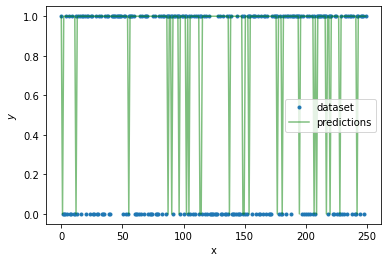

In [ ]:
model = LogisticRegression(n_feats_df2, n_tgts_df2)
optimizer = MiniBatchSGD()

yh = model.fit_gd(x_df2, y_df2.iloc[:, 0], optimizer).predict(x_df2)
yh = pd.Series(yh)

N, D = x_df2.shape
x = np.linspace(0, N, N)
plt.plot(x, y_df2, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

# Experiments

## Linear Regression and Fully Batched Logistic Regression Performance (3.1)

3.580786401425855
4.553749274673118
4.570297739079851
5.313018681711317


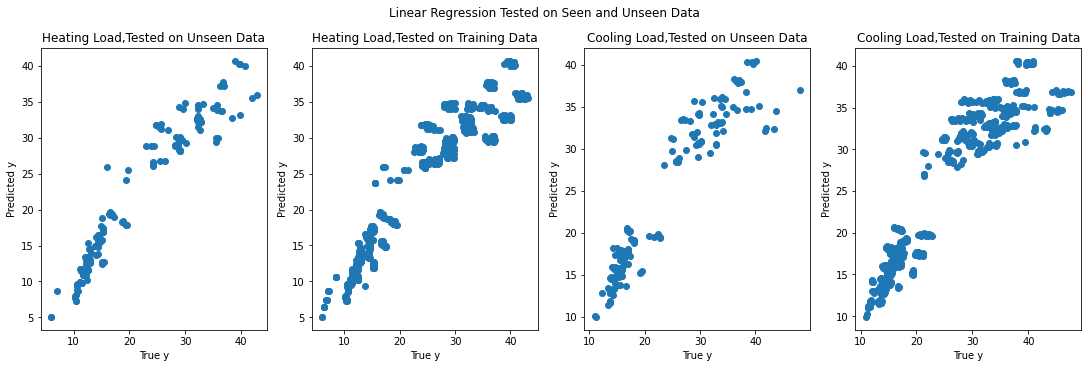

In [ ]:
X_train = df1.iloc[:614,:8]
Y_train_heat = df1.iloc[:614,8]
Y_train_cool = df1.iloc[:614,9]
X_test = df1.iloc[614:,:8] 
Y_true_heat = df1.iloc[614:,8]
Y_true_cool = df1.iloc[614:,9]
model = LinearRegression(8)

yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
yh_cool = model.fit_analytical(X_train,Y_train_cool).predict(X_test)

yh_heat_train = model.fit_analytical(X_train,Y_train_heat).predict(X_train)
yh_cool_train = model.fit_analytical(X_train,Y_train_cool).predict(X_train)

yh_heat_weights = model.fit_analytical(X_train,Y_train_heat).w
yh_cool_weights = model.fit_analytical(X_train,Y_train_cool ).w

fig, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(15,5))
fig.suptitle('Linear Regression Tested on Seen and Unseen Data')
axes[0].scatter(Y_true_heat,yh_heat)
axes[0].set_title('Heating Load,Tested on Unseen Data')
axes[0].set_xlabel('True y')
axes[0].set_ylabel('Predicted y')

axes[1].scatter(Y_train_heat,yh_heat_train)
axes[1].set_title('Heating Load,Tested on Training Data')
axes[1].set_xlabel('True y')
axes[1].set_ylabel('Predicted y')

axes[2].scatter(Y_true_cool,yh_cool)
axes[2].set_title('Cooling Load,Tested on Unseen Data')
axes[2].set_xlabel('True y')
axes[2].set_ylabel('Predicted y')

axes[3].scatter(Y_train_cool,yh_cool_train)
axes[3].set_title('Cooling Load,Tested on Training Data')
axes[3].set_xlabel('True y')
axes[3].set_ylabel('Predicted y')

#axes[2,1].scatter(Y_true_cool,yh_cool)
#axes[2, 1].set_title('Cooling Load,Tested on Training Data')
#axes[2, 1].set_xlabel('True y')
#axes[2, 1].set_ylabel('Predicted y')
print(model.mse(Y_true_heat,yh_heat))
print(model.mse(Y_train_heat,yh_heat_train))
print(model.mse(Y_true_cool,yh_cool))
print(model.mse(Y_train_cool,yh_cool_train))

In [ ]:
X_train = df2.iloc[:198,:12]
Y_train = df2.iloc[:198,12]
X_test = df2.iloc[198:,:12]
Y_true = df2.iloc[198:,12]

optimizer = GradientDescent(learning_rate=.01)
model = LogisticRegression(n_feats_df2)
fitted_model = model.fit_gd(X_train,Y_train,optimizer)
yh = fitted_model.predict(X_test)
yh_logisitc_weights = fitted_model.w
print(fitted_model.cost_fn(Y_true, yh))
print(confusion_matrix(Y_true, yh))

9.992007221626415e-16
[[20  0]
 [ 0 31]]


In [ ]:

yh = fitted_model.predict(X_train)
print(fitted_model.cost_fn(Y_train, yh))
print(confusion_matrix(Y_train, yh))

9.992007221626413e-16
[[ 87   0]
 [  0 111]]


## Linear and Logisitc weights (3.2)

In [ ]:
#Linear Regression weights

print(yh_heat_weights)
print('\n')
print(yh_cool_weights)


[-4.21488540e+00  1.24635596e+01 -5.88496894e+00 -1.80639013e+01
  7.47612843e+00 -4.09587928e-03  2.65344101e+00  3.08386913e-01
  2.24014728e+01]


[ -4.8518782   12.46084664  -6.65362614 -18.18769298   7.62358429
   0.11561756   1.99408069   0.08818438  24.67632348]


In [ ]:
#Logistic Regression weights

yh_logisitc_weights

array([-0.35410669,  0.39482572,  0.04408043,  0.62258585, -1.81077981,
        1.02467188, -1.6264213 ,  1.59044095, -2.9099181 ,  2.18773339,
        0.18804068,  0.87719109,  1.34364711])

## Growing subsets of the training data (3.3)

Text(0, 0.5, 'Cross entropy error')

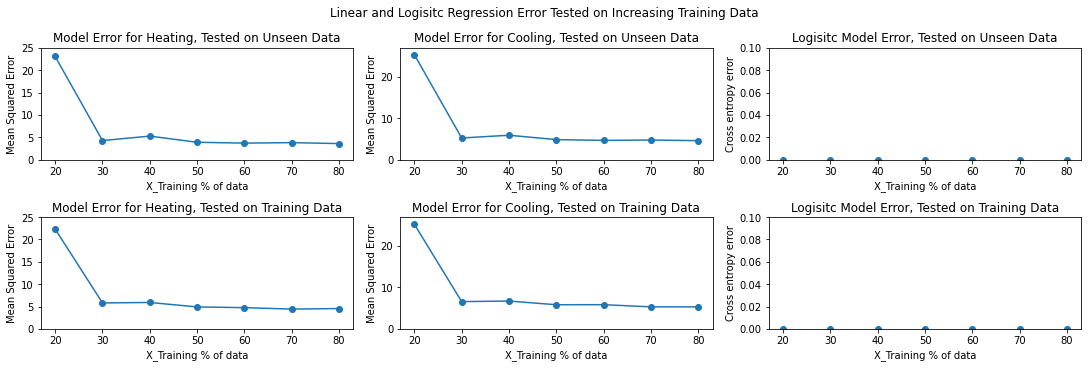

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,5))
fig.suptitle('Linear and Logisitc Regression Error Tested on Increasing Training Data')

X_train_20 = df1.iloc[:154,:8]
Y_train_20 = df1.iloc[:154,8]

X_train_30 = df1.iloc[:230,:8]
Y_train_30 = df1.iloc[:230,8]

X_train_40 = df1.iloc[:307,:8]
Y_train_40 = df1.iloc[:307,8]

X_train_50 = df1.iloc[:384,:8]
Y_train_50 = df1.iloc[:384,8]

X_train_60 = df1.iloc[:461,:8]
Y_train_60 = df1.iloc[:461,8]

X_train_70 = df1.iloc[:538,:8]
Y_train_70 = df1.iloc[:538,8]

X_train_80 = df1.iloc[:614,:8]
Y_train_80 = df1.iloc[:614,8]

X_test = df1.iloc[614:,:8]

model = LinearRegression(8)

yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_test)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_test)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_test)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_test)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_test)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_test)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_test)

mse_20 = model.mse(df1.iloc[614:,8],yh_heat_20)
mse_30 = model.mse(df1.iloc[614:,8],yh_heat_30)
mse_40 = model.mse(df1.iloc[614:,8],yh_heat_40)
mse_50 = model.mse(df1.iloc[614:,8],yh_heat_50)
mse_60 = model.mse(df1.iloc[614:,8],yh_heat_60)
mse_70 = model.mse(df1.iloc[614:,8],yh_heat_70)
mse_80 = model.mse(df1.iloc[614:,8],yh_heat_80)


x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
axes[0,0].set_ylim(0, 25)
axes[0,0].scatter(x, mse)
axes[0,0].plot(x, mse)
axes[0,0].set_title('Model Error for Heating, Tested on Unseen Data')
axes[0,0].set_xlabel("X_Training % of data")
axes[0,0].set_ylabel('Mean Squared Error')


yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_train_20)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_train_30)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_train_40)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_train_50)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_train_60)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_train_70)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_train_80)

mse_20 = model.mse(df1.iloc[:154,8],yh_heat_20)
mse_30 = model.mse(df1.iloc[:230,8],yh_heat_30)
mse_40 = model.mse(df1.iloc[:307,8],yh_heat_40)
mse_50 = model.mse(df1.iloc[:384,8],yh_heat_50)
mse_60 = model.mse(df1.iloc[:461,8],yh_heat_60)
mse_70 = model.mse(df1.iloc[:538,8],yh_heat_70)
mse_80 = model.mse(df1.iloc[:614,8],yh_heat_80)

x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
axes[1,0].set_ylim(0, 25)
axes[1,0].scatter(x, mse)
axes[1,0].plot(x, mse)
axes[1,0].set_title('Model Error for Heating, Tested on Training Data')
axes[1,0].set_xlabel("X_Training % of data")
axes[1,0].set_ylabel('Mean Squared Error')


X_train_20 = df1.iloc[:154,:8]
Y_train_20 = df1.iloc[:154,9]

X_train_30 = df1.iloc[:230,:8]
Y_train_30 = df1.iloc[:230,9]

X_train_40 = df1.iloc[:307,:8]
Y_train_40 = df1.iloc[:307,9]

X_train_50 = df1.iloc[:384,:8]
Y_train_50 = df1.iloc[:384,9]

X_train_60 = df1.iloc[:461,:8]
Y_train_60 = df1.iloc[:461,9]

X_train_70 = df1.iloc[:538,:8]
Y_train_70 = df1.iloc[:538,9]

X_train_80 = df1.iloc[:614,:8]
Y_train_80 = df1.iloc[:614,9]

X_test = df1.iloc[614:,:8]

yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_test)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_test)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_test)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_test)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_test)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_test)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_test)

mse_20 = model.mse(df1.iloc[614:,9],yh_heat_20)
mse_30 = model.mse(df1.iloc[614:,9],yh_heat_30)
mse_40 = model.mse(df1.iloc[614:,9],yh_heat_40)
mse_50 = model.mse(df1.iloc[614:,9],yh_heat_50)
mse_60 = model.mse(df1.iloc[614:,9],yh_heat_60)
mse_70 = model.mse(df1.iloc[614:,9],yh_heat_70)
mse_80 = model.mse(df1.iloc[614:,9],yh_heat_80)

mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
axes[0,1].set_ylim(0,27)
axes[0,1].scatter(x, mse)
axes[0,1].plot(x, mse)
axes[0,1].set_title('Model Error for Cooling, Tested on Unseen Data')
axes[0,1].set_xlabel("X_Training % of data")
axes[0,1].set_ylabel('Mean Squared Error')


yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_train_20)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_train_30)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_train_40)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_train_50)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_train_60)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_train_70)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_train_80)

mse_20 = model.mse(df1.iloc[:154,9],yh_heat_20)
mse_30 = model.mse(df1.iloc[:230,9],yh_heat_30)
mse_40 = model.mse(df1.iloc[:307,9],yh_heat_40)
mse_50 = model.mse(df1.iloc[:384,9],yh_heat_50)
mse_60 = model.mse(df1.iloc[:461,9],yh_heat_60)
mse_70 = model.mse(df1.iloc[:538,9],yh_heat_70)
mse_80 = model.mse(df1.iloc[:614,9],yh_heat_80)

x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
axes[1,1].set_ylim(0, 27)
axes[1,1].scatter(x, mse)
axes[1,1].plot(x, mse)
axes[1,1].set_title('Model Error for Cooling, Tested on Training Data')
axes[1,1].set_xlabel("X_Training % of data")
axes[1,1].set_ylabel('Mean Squared Error')


X_train_20 = df2.iloc[:50,:12]
Y_train_20 = df2.iloc[:50,12]

X_train_30 = df2.iloc[:75,:12]
Y_train_30 = df2.iloc[:75,12]

X_train_40 = df2.iloc[:100,:12]
Y_train_40 = df2.iloc[:100,12]

X_train_50 = df2.iloc[:125,:12]
Y_train_50 = df2.iloc[:125,12]

X_train_60 = df2.iloc[:150,:12]
Y_train_60 = df2.iloc[:150,12]

X_train_70 = df2.iloc[:175,:12]
Y_train_70 = df2.iloc[:175,12]

X_train_80 = df2.iloc[:200,:12]
Y_train_80 = df2.iloc[:200,12]

X_test = df2.iloc[200:,:12]

optimizer = GradientDescent(learning_rate=.01)
model = LogisticRegression(n_feats_df2)


yh_20 = model.fit_gd(X_train_20,Y_train_20,optimizer).predict(X_test)
yh_30 = model.fit_gd(X_train_30,Y_train_30,optimizer).predict(X_test)
yh_40 = model.fit_gd(X_train_40,Y_train_40,optimizer).predict(X_test)
yh_50 = model.fit_gd(X_train_50,Y_train_50,optimizer).predict(X_test)
yh_60 = model.fit_gd(X_train_60,Y_train_60,optimizer).predict(X_test)
yh_70 = model.fit_gd(X_train_70,Y_train_70,optimizer).predict(X_test)
yh_80 = model.fit_gd(X_train_80,Y_train_80,optimizer).predict(X_test)

roc_20 = model.cost_fn(df2.iloc[200:,12],yh_20)
roc_30 = model.cost_fn(df2.iloc[200:,12],yh_30)
roc_40 = model.cost_fn(df2.iloc[200:,12],yh_40)
roc_50 = model.cost_fn(df2.iloc[200:,12],yh_50)
roc_60 = model.cost_fn(df2.iloc[200:,12],yh_60)
roc_70 = model.cost_fn(df2.iloc[200:,12],yh_70)
roc_80 = model.cost_fn(df2.iloc[200:,12],yh_80)

x = [20,30,40,50,60,70,80]
roc = [roc_20,roc_30,roc_40,roc_50,roc_60,roc_70,roc_80]
axes[0,2].set_ylim(0, 0.1)
axes[0,2].scatter(x, roc)
axes[0,2].set_title('Logisitc Model Error, Tested on Unseen Data')
axes[0,2].set_xlabel("X_Training % of data")
axes[0,2].set_ylabel('Cross entropy error')

yh_20 = model.fit_gd(X_train_20,Y_train_20,optimizer).predict(X_train_20)
yh_30 = model.fit_gd(X_train_30,Y_train_30,optimizer).predict(X_train_30)
yh_40 = model.fit_gd(X_train_40,Y_train_40,optimizer).predict(X_train_40)
yh_50 = model.fit_gd(X_train_50,Y_train_50,optimizer).predict(X_train_50)
yh_60 = model.fit_gd(X_train_60,Y_train_60,optimizer).predict(X_train_60)
yh_70 = model.fit_gd(X_train_70,Y_train_70,optimizer).predict(X_train_70)
yh_80 = model.fit_gd(X_train_80,Y_train_80,optimizer).predict(X_train_80)

roc_20 = model.cost_fn(df2.iloc[:50,12],yh_20)
roc_30 = model.cost_fn(df2.iloc[:75,12],yh_30)
roc_40 = model.cost_fn(df2.iloc[:100,12],yh_40)
roc_50 = model.cost_fn(df2.iloc[:125,12],yh_50)
roc_60 = model.cost_fn(df2.iloc[:150,12],yh_60)
roc_70 = model.cost_fn(df2.iloc[:175,12],yh_70)
roc_80 = model.cost_fn(df2.iloc[:200,12],yh_80)

x = [20,30,40,50,60,70,80]
roc = [roc_20,roc_30,roc_40,roc_50,roc_60,roc_70,roc_80]
axes[1,2].set_ylim(0, 0.1)
axes[1,2].scatter(x, roc)
axes[1,2].set_title('Logisitc Model Error, Tested on Training Data')
axes[1,2].set_xlabel("X_Training % of data")
axes[1,2].set_ylabel('Cross entropy error')


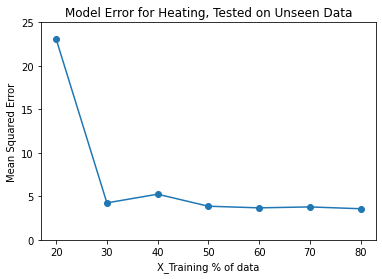

In [ ]:
X_train_20 = df1.iloc[:154,:8]
Y_train_20 = df1.iloc[:154,8]

X_train_30 = df1.iloc[:230,:8]
Y_train_30 = df1.iloc[:230,8]

X_train_40 = df1.iloc[:307,:8]
Y_train_40 = df1.iloc[:307,8]

X_train_50 = df1.iloc[:384,:8]
Y_train_50 = df1.iloc[:384,8]

X_train_60 = df1.iloc[:461,:8]
Y_train_60 = df1.iloc[:461,8]

X_train_70 = df1.iloc[:538,:8]
Y_train_70 = df1.iloc[:538,8]

X_train_80 = df1.iloc[:614,:8]
Y_train_80 = df1.iloc[:614,8]

X_test = df1.iloc[614:,:8]


model = LinearRegression(8)

yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_test)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_test)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_test)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_test)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_test)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_test)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_test)

mse_20 = model.mse(df1.iloc[614:,8],yh_heat_20)
mse_30 = model.mse(df1.iloc[614:,8],yh_heat_30)
mse_40 = model.mse(df1.iloc[614:,8],yh_heat_40)
mse_50 = model.mse(df1.iloc[614:,8],yh_heat_50)
mse_60 = model.mse(df1.iloc[614:,8],yh_heat_60)
mse_70 = model.mse(df1.iloc[614:,8],yh_heat_70)
mse_80 = model.mse(df1.iloc[614:,8],yh_heat_80)

x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
plt.ylim(0, 25)
plt.scatter(x, mse)
plt.plot(x, mse)
plt.title('Model Error for Heating, Tested on Unseen Data')
plt.xlabel("X_Training % of data")
plt.ylabel('Mean Squared Error')
plt.show()




In [ ]:
for i in mse:
  print(i)

23.07609139842144
4.254424161896751
5.253933900446276
3.8718183226639433
3.683492480918313
3.7919151431616656
3.580786401425855


In [ ]:
X_train_20 = df1.iloc[:154,:8]
Y_train_20 = df1.iloc[:154,9]

X_train_30 = df1.iloc[:230,:8]
Y_train_30 = df1.iloc[:230,9]

X_train_40 = df1.iloc[:307,:8]
Y_train_40 = df1.iloc[:307,9]

X_train_50 = df1.iloc[:384,:8]
Y_train_50 = df1.iloc[:384,9]

X_train_60 = df1.iloc[:461,:8]
Y_train_60 = df1.iloc[:461,9]

X_train_70 = df1.iloc[:538,:8]
Y_train_70 = df1.iloc[:538,9]

X_train_80 = df1.iloc[:614,:8]
Y_train_80 = df1.iloc[:614,9]

X_test = df1.iloc[614:,:8]

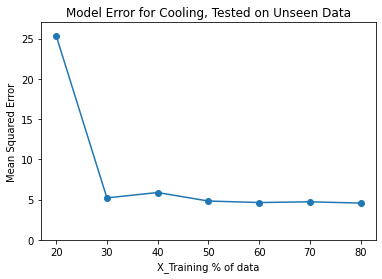

In [ ]:
model = LinearRegression(8)

yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_test)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_test)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_test)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_test)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_test)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_test)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_test)

mse_20 = model.mse(df1.iloc[614:,9],yh_heat_20)
mse_30 = model.mse(df1.iloc[614:,9],yh_heat_30)
mse_40 = model.mse(df1.iloc[614:,9],yh_heat_40)
mse_50 = model.mse(df1.iloc[614:,9],yh_heat_50)
mse_60 = model.mse(df1.iloc[614:,9],yh_heat_60)
mse_70 = model.mse(df1.iloc[614:,9],yh_heat_70)
mse_80 = model.mse(df1.iloc[614:,9],yh_heat_80)

x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
plt.ylim(0,27)
plt.scatter(x, mse)
plt.plot(x, mse)
plt.title('Model Error for Cooling, Tested on Unseen Data')
plt.xlabel("X_Training % of data")
plt.ylabel('Mean Squared Error')
plt.show()


In [ ]:
for i in mse:
  print(i)

25.35536309945803
5.215927484515543
5.8818727720953
4.825747271138149
4.639067418365759
4.729257384308932
4.570297739079851


In [ ]:
X_train_20 = df1.iloc[:154,:8]
Y_train_20 = df1.iloc[:154,8]

X_train_30 = df1.iloc[:230,:8]
Y_train_30 = df1.iloc[:230,8]

X_train_40 = df1.iloc[:307,:8]
Y_train_40 = df1.iloc[:307,8]

X_train_50 = df1.iloc[:384,:8]
Y_train_50 = df1.iloc[:384,8]

X_train_60 = df1.iloc[:461,:8]
Y_train_60 = df1.iloc[:461,8]

X_train_70 = df1.iloc[:538,:8]
Y_train_70 = df1.iloc[:538,8]

X_train_80 = df1.iloc[:614,:8]
Y_train_80 = df1.iloc[:614,8]


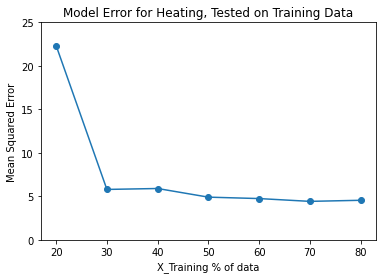

In [ ]:
model = LinearRegression(8)

yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_train_20)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_train_30)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_train_40)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_train_50)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_train_60)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_train_70)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_train_80)

mse_20 = model.mse(df1.iloc[:154,8],yh_heat_20)
mse_30 = model.mse(df1.iloc[:230,8],yh_heat_30)
mse_40 = model.mse(df1.iloc[:307,8],yh_heat_40)
mse_50 = model.mse(df1.iloc[:384,8],yh_heat_50)
mse_60 = model.mse(df1.iloc[:461,8],yh_heat_60)
mse_70 = model.mse(df1.iloc[:538,8],yh_heat_70)
mse_80 = model.mse(df1.iloc[:614,8],yh_heat_80)

x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
plt.ylim(0, 25)
plt.scatter(x, mse)
plt.plot(x, mse)
plt.title('Model Error for Heating, Tested on Training Data')
plt.xlabel("X_Training % of data")
plt.ylabel('Mean Squared Error')
plt.show()


In [ ]:
for i in mse:
  print(i)

22.329360958174792
5.8021860655985
5.908182345593639
4.914925472435855
4.751329939840052
4.430093346635316
4.553749274673118


In [ ]:
X_train_20 = df1.iloc[:154,:8]
Y_train_20 = df1.iloc[:154,9]

X_train_30 = df1.iloc[:230,:8]
Y_train_30 = df1.iloc[:230,9]

X_train_40 = df1.iloc[:307,:8]
Y_train_40 = df1.iloc[:307,9]

X_train_50 = df1.iloc[:384,:8]
Y_train_50 = df1.iloc[:384,9]

X_train_60 = df1.iloc[:461,:8]
Y_train_60 = df1.iloc[:461,9]

X_train_70 = df1.iloc[:538,:8]
Y_train_70 = df1.iloc[:538,9]

X_train_80 = df1.iloc[:614,:8]
Y_train_80 = df1.iloc[:614,9]

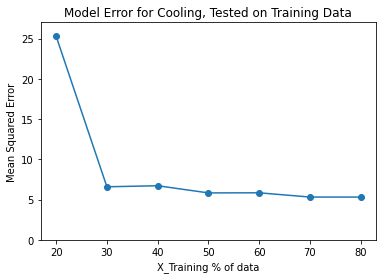

In [ ]:
yh_heat_20 = model.fit_analytical(X_train_20,Y_train_20).predict(X_train_20)
yh_heat_30 = model.fit_analytical(X_train_30,Y_train_30).predict(X_train_30)
yh_heat_40 = model.fit_analytical(X_train_40,Y_train_40).predict(X_train_40)
yh_heat_50 = model.fit_analytical(X_train_50,Y_train_50).predict(X_train_50)
yh_heat_60 = model.fit_analytical(X_train_60,Y_train_60).predict(X_train_60)
yh_heat_70 = model.fit_analytical(X_train_70,Y_train_70).predict(X_train_70)
yh_heat_80 = model.fit_analytical(X_train_80,Y_train_80).predict(X_train_80)

mse_20 = model.mse(df1.iloc[:154,9],yh_heat_20)
mse_30 = model.mse(df1.iloc[:230,9],yh_heat_30)
mse_40 = model.mse(df1.iloc[:307,9],yh_heat_40)
mse_50 = model.mse(df1.iloc[:384,9],yh_heat_50)
mse_60 = model.mse(df1.iloc[:461,9],yh_heat_60)
mse_70 = model.mse(df1.iloc[:538,9],yh_heat_70)
mse_80 = model.mse(df1.iloc[:614,9],yh_heat_80)

x = [20,30,40,50,60,70,80]
mse = [mse_20,mse_30,mse_40,mse_50,mse_60,mse_70,mse_80]
plt.ylim(0, 27)
plt.scatter(x, mse)
plt.plot(x, mse)
plt.title('Model Error for Cooling, Tested on Training Data')
plt.xlabel("X_Training % of data")
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
for i in mse:
  print(i)

25.27938734084144
6.59346485131824
6.725013141766701
5.833916719182912
5.847002230588433
5.321517780089429
5.313018681711317


In [ ]:
X_train_20 = df2.iloc[:50,:12]
Y_train_20 = df2.iloc[:50,12]

X_train_30 = df2.iloc[:75,:12]
Y_train_30 = df2.iloc[:75,12]

X_train_40 = df2.iloc[:100,:12]
Y_train_40 = df2.iloc[:100,12]

X_train_50 = df2.iloc[:125,:12]
Y_train_50 = df2.iloc[:125,12]

X_train_60 = df2.iloc[:150,:12]
Y_train_60 = df2.iloc[:150,12]

X_train_70 = df2.iloc[:175,:12]
Y_train_70 = df2.iloc[:175,12]

X_train_80 = df2.iloc[:200,:12]
Y_train_80 = df2.iloc[:200,12]

X_test = df2.iloc[200:,:12]


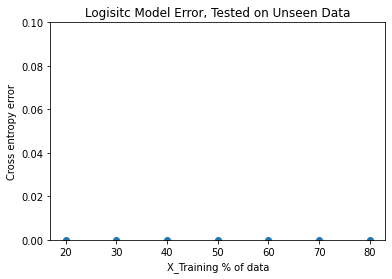

In [ ]:
optimizer = GradientDescent(learning_rate=.01)
model = LogisticRegression(n_feats_df2)


yh_20 = model.fit_gd(X_train_20,Y_train_20,optimizer).predict(X_test)
yh_30 = model.fit_gd(X_train_30,Y_train_30,optimizer).predict(X_test)
yh_40 = model.fit_gd(X_train_40,Y_train_40,optimizer).predict(X_test)
yh_50 = model.fit_gd(X_train_50,Y_train_50,optimizer).predict(X_test)
yh_60 = model.fit_gd(X_train_60,Y_train_60,optimizer).predict(X_test)
yh_70 = model.fit_gd(X_train_70,Y_train_70,optimizer).predict(X_test)
yh_80 = model.fit_gd(X_train_80,Y_train_80,optimizer).predict(X_test)

roc_20 = model.cost_fn(df2.iloc[200:,12],yh_20)
roc_30 = model.cost_fn(df2.iloc[200:,12],yh_30)
roc_40 = model.cost_fn(df2.iloc[200:,12],yh_40)
roc_50 = model.cost_fn(df2.iloc[200:,12],yh_50)
roc_60 = model.cost_fn(df2.iloc[200:,12],yh_60)
roc_70 = model.cost_fn(df2.iloc[200:,12],yh_70)
roc_80 = model.cost_fn(df2.iloc[200:,12],yh_80)

x = [20,30,40,50,60,70,80]
roc = [roc_20,roc_30,roc_40,roc_50,roc_60,roc_70,roc_80]
plt.ylim(0, 0.1)
plt.scatter(x, roc)
plt.title('Logisitc Model Error, Tested on Unseen Data')
plt.xlabel("X_Training % of data")
plt.ylabel('Cross entropy error')
plt.show()


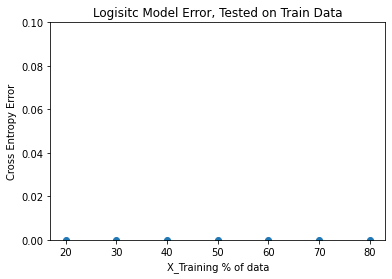

In [ ]:

yh_20 = model.fit_gd(X_train_20,Y_train_20,optimizer).predict(X_train_20)
yh_30 = model.fit_gd(X_train_30,Y_train_30,optimizer).predict(X_train_30)
yh_40 = model.fit_gd(X_train_40,Y_train_40,optimizer).predict(X_train_40)
yh_50 = model.fit_gd(X_train_50,Y_train_50,optimizer).predict(X_train_50)
yh_60 = model.fit_gd(X_train_60,Y_train_60,optimizer).predict(X_train_60)
yh_70 = model.fit_gd(X_train_70,Y_train_70,optimizer).predict(X_train_70)
yh_80 = model.fit_gd(X_train_80,Y_train_80,optimizer).predict(X_train_80)

roc_20 = model.cost_fn(df2.iloc[:50,12],yh_20)
roc_30 = model.cost_fn(df2.iloc[:75,12],yh_30)
roc_40 = model.cost_fn(df2.iloc[:100,12],yh_40)
roc_50 = model.cost_fn(df2.iloc[:125,12],yh_50)
roc_60 = model.cost_fn(df2.iloc[:150,12],yh_60)
roc_70 = model.cost_fn(df2.iloc[:175,12],yh_70)
roc_80 = model.cost_fn(df2.iloc[:200,12],yh_80)

x = [20,30,40,50,60,70,80]
roc = [roc_20,roc_30,roc_40,roc_50,roc_60,roc_70,roc_80]
plt.ylim(0, 0.1)
plt.scatter(x, roc)
plt.title('Logisitc Model Error, Tested on Train Data')
plt.xlabel("X_Training % of data")
plt.ylabel('Cross Entropy Error')
plt.show()

In [ ]:
for i in roc:
  print(i)

9.992007221626415e-16
9.992007221626415e-16
9.992007221626413e-16
9.992007221626413e-16
9.992007221626415e-16
9.992007221626413e-16
9.992007221626413e-16


In [ ]:
print(confusion_matrix(df2.iloc[:50,12],yh_20))
print(confusion_matrix(df2.iloc[:75,12],yh_30))
print(confusion_matrix(df2.iloc[:100,12],yh_40))
print(confusion_matrix(df2.iloc[:125,12],yh_50))
print(confusion_matrix(df2.iloc[:150,12],yh_60))
print(confusion_matrix(df2.iloc[:175,12],yh_70))
print(confusion_matrix(df2.iloc[:200,12],yh_80))

[[21  0]
 [ 0 29]]
[[34  0]
 [ 0 41]]
[[41  0]
 [ 0 59]]
[[54  0]
 [ 0 71]]
[[70  0]
 [ 0 80]]
[[81  0]
 [ 0 94]]
[[ 89   0]
 [  0 111]]


## Different minibatch sizes (3.4)

In [ ]:
# Split into training and test set (80/20)
x_df1_train, x_df1_test, y_df1_train, y_df1_test = train_test_split(x_df1, y_df1, test_size=0.2, random_state=10)
x_df2_train, x_df2_test, y_df2_train, y_df2_test = train_test_split(x_df2, y_df2, test_size=0.2, random_state=10)


# Models
lin_model = LinearRegression(n_feats_df1, n_tgts_df1)
log_model = LogisticRegression(n_feats_df2, n_tgts_df2)


# Fully batched baseline
gd_optimizer = GradientDescent(verbose=True)

yh_df1_base = lin_model.fit_gd(x_df1_train, y_df1_train.iloc[:, 0], gd_optimizer).predict(x_df1_test) # baseline y predicts
cost_df1_base = LinearRegression.cost_fn(y_df1_test.iloc[:, 0], yh_df1_base)                              # baseline cost

fit_model_df2 = log_model.fit_gd(x_df2_train, y_df2_train.iloc[:, 0], gd_optimizer)
w_df2_base = fit_model_df2.w
yh_df2_base = fit_model_df2.predict(x_df2_test)
N, D = x_df2_test.shape
# cost_df2_base = LogisticRegression.cost_fn(np.column_stack([x_df2_test,np.ones(N)]), y_df2_test.iloc[:, 0], w_df2_base)
cost_df2_base = LogisticRegression.cost_fn(y_df2_test.iloc[:, 0], yh_df2_base)

# Run minibatch with different sizes (8, 16, 32, 64, 128) for dataset 1
batch_size = 8
cost_history_minib_df1 = [] # list of cost history lists (for each batch size)
final_costs_minib_df1 = []  # list of final costs (for each batch size)

for _ in range(5):
  minib_sgd_optimizer = MiniBatchSGD(batch_size=batch_size, n_epochs=64, record_history=True)
  lin_model.fit_gd(x_df1_train, y_df1_train.iloc[:, 0], minib_sgd_optimizer).predict(x_df1_test)
  cost_h = minib_sgd_optimizer.cost_history
  cost_history_minib_df1.append(cost_h)
  final_costs_minib_df1.append(cost_h[-1])
  batch_size = batch_size*2


# Run minibatch with different sizes (8, 16, 32, 64, 128) for dataset 2
batch_size = 8
cost_history_df2 = []
final_costs_minib_df2 = []  # list of final costs (for each batch size)
for _ in range(5):
  minib_sgd_optimizer = MiniBatchSGD(batch_size=batch_size, n_epochs=64, record_history=True)
  log_model.fit_gd(x_df2_train, y_df2_train.iloc[:, 0], minib_sgd_optimizer).predict(x_df2_test)
  cost_h = minib_sgd_optimizer.cost_history
  cost_history_df2.append(cost_h)
  final_costs_minib_df2.append(cost_h[-1])
  batch_size = batch_size*2

terminated after 10000 iterations, with norm of the gradient equal to 0.015659776279196007
the weight found: [-4.14197227 -1.61810279  1.04899465 -2.08449434  8.66187432 -0.0238328
  2.71586641  0.32819006 22.33478771]
terminated after 10000 iterations, with norm of the gradient equal to 0.015458803608851357
the weight found: [-0.45113515  0.47240939 -0.02188638  0.81246954 -1.87030108  0.9660803
 -1.58222939  1.50290416 -2.86873528  2.18618281  0.22581243  0.82537206
  1.40384075]


In [ ]:
final_costs_minib_df1

[98.31509888331466,
 97.64481204599065,
 97.18272822947989,
 97.08476692562915,
 100.73235133332568]

In [ ]:
final_costs_minib_df2

[0.5901864296694919,
 0.599822416476691,
 0.6088446656293343,
 0.6218305745081723,
 0.6415099131799651]

Linear Regression   - Fully batched baseline cost:  6.933087607811434
Logistic Regression - Fully batched baseline cost:  9.992007221626415e-16


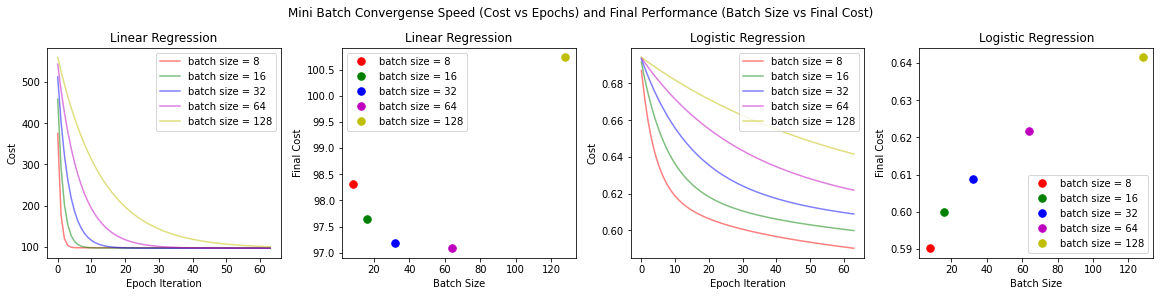

In [ ]:
# Convergence Speed and Final Performance
print("Linear Regression   - Fully batched baseline cost: ", cost_df1_base)
print("Logistic Regression - Fully batched baseline cost: ", cost_df2_base)

fig, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(16, 4))
colors = ['r','g', 'b', 'm', 'y']
batch_size = 8
for i in range(5):
  axes[0].plot(cost_history_minib_df1[i], '-'+colors[i], alpha=.5, label =(f'batch size = {batch_size}'))
  axes[1].plot(batch_size, final_costs_minib_df1[i], '.', markersize=15, markeredgecolor=colors[i], markerfacecolor=colors[i], label=(f'batch size = {batch_size}'))
  axes[2].plot(cost_history_df2[i], '-'+colors[i], alpha=.5, label=(f'batch size = {batch_size}'))
  axes[3].plot(batch_size, final_costs_minib_df2[i], '.', markersize=15, markeredgecolor=colors[i], markerfacecolor=colors[i], label=(f'batch size = {batch_size}'))
  batch_size = batch_size*2
fig.suptitle('Mini Batch Convergense Speed (Cost vs Epochs) and Final Performance (Batch Size vs Final Cost)')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Epoch Iteration')
axes[0].set_ylabel('Cost')
axes[1].set_title('Linear Regression')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Final Cost')
axes[2].set_title('Logistic Regression')
axes[2].set_xlabel('Epoch Iteration')
axes[2].set_ylabel('Cost')
axes[3].set_title('Logistic Regression')
axes[3].set_xlabel('Batch Size')
axes[3].set_ylabel('Final Cost')
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.show()

Linear Regression   - Fully batched baseline cost:  6.933087607811434
Logistic Regression - Fully batched baseline cost:  9.992007221626415e-16


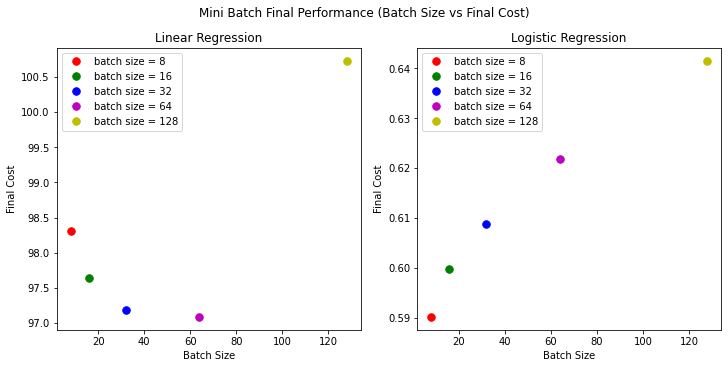

In [ ]:
# Final performance
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
colors = ['r','g', 'b', 'm', 'y']
batch_size = 8
print("Linear Regression   - Fully batched baseline cost: ", cost_df1_base)
print("Logistic Regression - Fully batched baseline cost: ", cost_df2_base)
for i in range(5):
  axes[0].plot(batch_size, final_costs_minib_df1[i], '.', markersize=15, markeredgecolor=colors[i], markerfacecolor=colors[i], label=(f'batch size = {batch_size}'))
  axes[1].plot(batch_size, final_costs_minib_df2[i], '.', markersize=15, markeredgecolor=colors[i], markerfacecolor=colors[i], label=(f'batch size = {batch_size}'))
  batch_size = batch_size*2

fig.suptitle('Mini Batch Final Performance (Batch Size vs Final Cost)')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Final Cost')
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Final Cost')
axes[0].legend()
axes[1].legend()
plt.show()

## Different learning rates (3.5)

In [ ]:
# Split into training and test set (80/20)
x_df1_train, x_df1_test, y_df1_train, y_df1_test = train_test_split(x_df1, y_df1, test_size=0.2, random_state=10)
x_df2_train, x_df2_test, y_df2_train, y_df2_test = train_test_split(x_df2, y_df2, test_size=0.2, random_state=10)

# Models
lin_model = LinearRegression(n_feats_df1, n_tgts_df1)
log_model = LogisticRegression(n_feats_df2, n_tgts_df2)

learning_rates = [0.001, 0.01, 0.05, 0.1, 0.3, 0.4]
lin_mse = []
log_accuracy = []
for i, lr in enumerate(learning_rates):
  optimizer = GradientDescent(learning_rate=lr, max_iters=50, record_history=True)

  yh = lin_model.fit_gd(x_df1_train, y_df1_train.iloc[:, 0], optimizer).predict(x_df1_test)
  w_hist = np.vstack(optimizer.w_history)                
  N, D = x_df1_test.shape
  cost_gen = ((LinearRegression.cost_fn(y_df1_test.iloc[:, 0], LinearRegression.predict_fn(np.column_stack([x_df1_test,np.ones(N)]), w_hist[j]))) for j in range(0, w_hist.shape[0]))
  cost_list = np.fromiter(cost_gen,dtype=float,count=-1)
  lin_mse.append(cost_list)

  yh = log_model.fit_gd(x_df2_train, y_df2_train.iloc[:, 0], optimizer).predict(x_df2_test)
  w_hist = np.vstack(optimizer.w_history) 
  N, D = x_df2_test.shape
  cost_gen = ((LogisticRegression.cost_fn(y_df2_test.iloc[:, 0], LogisticRegression.predict_fn(np.column_stack([x_df2_test,np.ones(N)]), w_hist[j]))) for j in range(0, w_hist.shape[0]))
  cost_list = np.fromiter(cost_gen,dtype=float,count=-1)
  log_accuracy.append(cost_list)

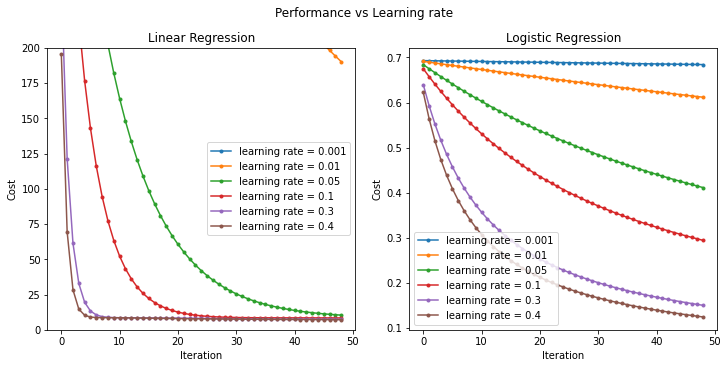

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
fig.suptitle('Performance vs Learning rate')
for i, lr in enumerate(learning_rates):
    axes[0].plot(list(lin_mse[i]), marker= '.', alpha=.998, label =(f'learning rate = {lr}') )
    axes[1].plot(list(log_accuracy[i]), marker= '.', alpha=.998, label =(f'learning rate = {lr}') )
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost')
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Cost')
axes[0].set_ylim([0,200])
axes[0].legend()
axes[1].legend()
plt.show()

## Non-Linear Bases

In [ ]:
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)

30.08407023709021


Text(0.5, 1.0, 'Heating Load Analytical')

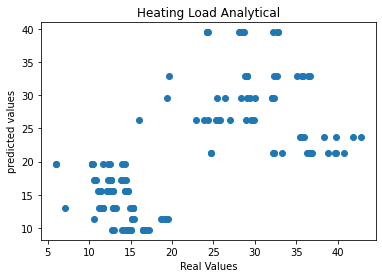

In [ ]:
features = df1.iloc[:,:1].to_numpy()

mu=np.linspace(0,10,768)

phi_1= np.ones((features.shape[0], 1))

for j in range(1):
  for i in range(features.shape[0]):
    phi_1[i,j] *= gaussian(features[i,j], mu[i],1)


model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,:1]
X_train = phi_1[:614,:1]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



29.353252068927993


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

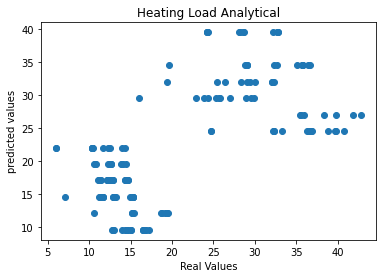

In [ ]:
features = df1.iloc[:,1].to_numpy()

mu=np.linspace(0,10,768)

phi_2= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_2[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,1]
X_train = phi_2[:614,:1]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



37.89762208345534


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

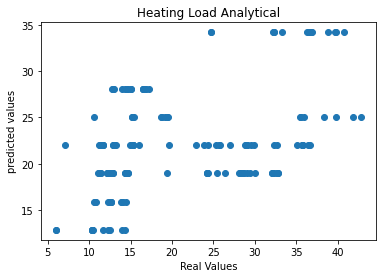

In [ ]:
features = df1.iloc[:,2].to_numpy()

mu=np.linspace(0,10,768)

phi_3= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_3[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,2]
X_train = phi_3[:614,:2]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



16.667060178654857


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

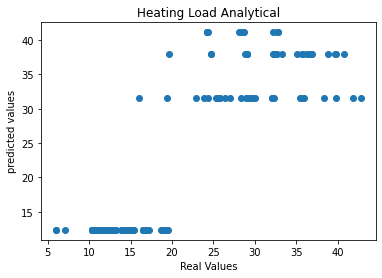

In [ ]:
features = df1.iloc[:,3].to_numpy()

mu=np.linspace(0,10,768)

phi_4= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_4[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,3]
X_train = phi_4[:614,:3]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



15.178540988569626


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

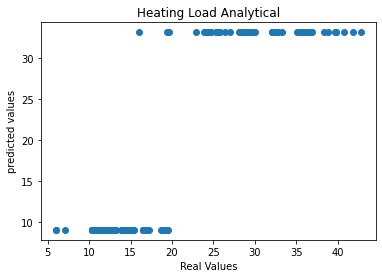

In [ ]:
features = df1.iloc[:,4].to_numpy()

mu=np.linspace(0,10,768)

phi_5= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_5[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,4]
X_train = phi_5[:614,:4]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



49.23749005353922


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

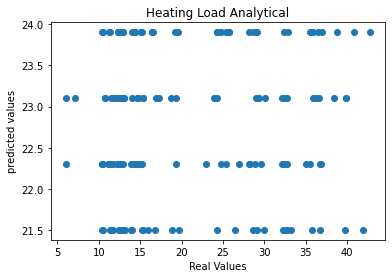

In [ ]:
features = df1.iloc[:,5].to_numpy()

mu=np.linspace(0,10,768)

phi_6= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_6[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,5]
X_train = phi_6[:614,:5]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



48.920834854776345


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

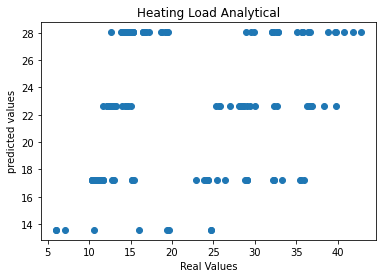

In [ ]:
features = df1.iloc[:,6].to_numpy()

mu=np.linspace(0,10,768)

phi_7= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_7[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,6]
X_train = phi_7[:614,:6]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



In [ ]:
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)

48.677844944084065


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

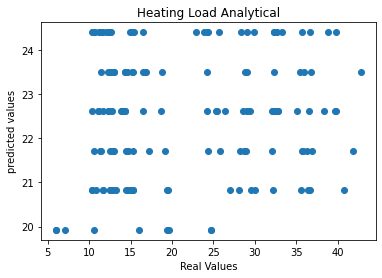

In [ ]:
features = df1.iloc[:,7].to_numpy()

mu=np.linspace(0,10,768)

phi_8= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_8[i] *= gaussian(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,7]
X_train = phi_8[:614,:7]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



In [ ]:
df1

,Compactness,Surface Area,Wall Area,Roof Area,Height,Orientation,Glazing Area,Glazing Area Dis,Heating Load,Cooling Load
285,-1.362924,1.552931,1.123171,0.971879,-0.999349,-0.446922,-1.008666,1.410417,12.74,13.97
101,1.284142,-1.228438,0.000000,-1.197897,0.999349,-0.446922,-1.008666,-0.523869,29.68,29.44
581,1.284142,-1.228438,0.000000,-1.197897,0.999349,-0.446922,1.243239,-0.523869,36.57,35.39
352,0.244223,-0.394027,0.561586,-0.655453,0.999349,-1.340767,0.117287,-0.523869,38.57,43.86
726,1.284142,-1.228438,0.000000,-1.197897,0.999349,0.446922,1.243239,1.410417,34.72,38.79
...,...,...,...,...,...,...,...,...,...,...
645,-0.039391,-0.115890,2.246342,-1.197897,0.999349,-0.446922,1.243239,0.120893,39.84,38.48
715,-1.173848,1.274794,0.561586,0.971879,-0.999349,1.340767,1.243239,0.765655,18.84,22.49
72,-0.228467,0.162247,-1.684757,0.971879,-0.999349,-1.340767,-1.008666,-1.168631,10.36,13.43
235,-1.173848,1.274794,0.561586,0.971879,-0.999349,1.340767,-1.008666,0.765655,15.16,19.48


In [ ]:
df1.iloc[:,:3]

,Compactness,Surface Area,Wall Area
285,-1.362924,1.552931,1.123171
101,1.284142,-1.228438,0.000000
581,1.284142,-1.228438,0.000000
352,0.244223,-0.394027,0.561586
726,1.284142,-1.228438,0.000000
...,...,...,...
645,-0.039391,-0.115890,2.246342
715,-1.173848,1.274794,0.561586
72,-0.228467,0.162247,-1.684757
235,-1.173848,1.274794,0.561586


4.313924465587919


Text(0.5, 1.0, 'Heating Load Analytical with 2 Gaussian Features')

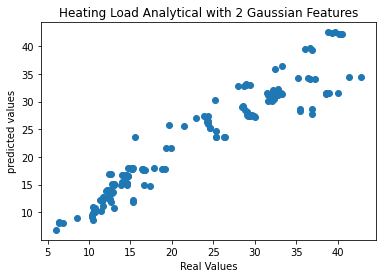

In [ ]:
df_gauss = pd.concat([df1.iloc[:,:3],pd.DataFrame(phi_4),pd.DataFrame(phi_5),df1.iloc[:,5:8],df1.iloc[:,8]], axis=1)
df_gauss = df_gauss.sample(frac=1, random_state=4)

model = LinearRegression(8)
Y_true_heat = df_gauss.iloc[614:,8]
X_test = df_gauss.iloc[614:,:8]
X_train = df_gauss.iloc[:614,:8]
Y_train_heat = df_gauss.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical with 2 Gaussian Features")

In [ ]:
Y_true_heat

29      6.40
498    39.01
457    12.30
5      21.46
634    32.05
       ...  
360    12.35
709    15.29
439    33.28
174    10.68
122    10.32
Name: Heating Load, Length: 154, dtype: float64

In [ ]:
df1.iloc[:,8]

285    12.74
101    29.68
581    36.57
352    38.57
726    34.72
       ...  
645    39.84
715    18.84
72     10.36
235    15.16
37      7.10
Name: Heating Load, Length: 768, dtype: float64

##Sigmoid

In [ ]:
sigmoid = lambda x,mu, s: 1/(1 + np.exp(-(x - mu)/s))

67.63229829840762


Text(0.5, 1.0, 'Heating Load Analytical')

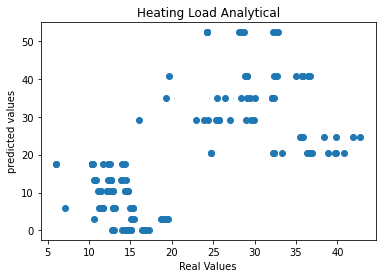

In [ ]:
features = df1.iloc[:,:1].to_numpy()

mu=np.linspace(0,10,768)

phi_1= np.ones((features.shape[0], 1))

for j in range(1):
  for i in range(features.shape[0]):
    phi_1[i,j] *= sigmoid(features[i,j], mu[i],1)


model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,:1]
X_train = phi_1[:614,:1]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



49.078893161016


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

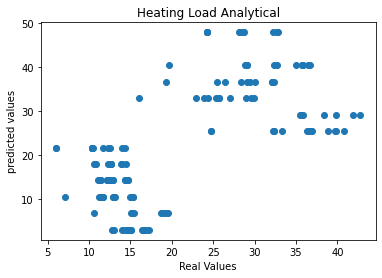

In [ ]:
features = df1.iloc[:,1].to_numpy()

mu=np.linspace(0,10,768)

phi_2= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_2[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,1]
X_train = phi_2[:614,:1]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


57.8580678581226


Text(0.5, 1.0, 'Heating Load Analytical')

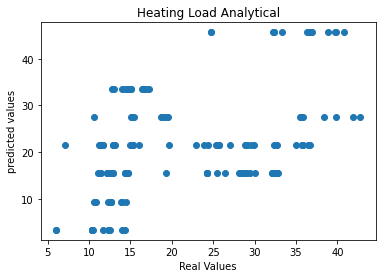

In [ ]:
features = df1.iloc[:,2].to_numpy()

mu=np.linspace(0,10,768)

phi_3= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_3[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,2]
X_train = phi_3[:614,:2]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


51.53198412472971


Text(0.5, 1.0, 'Heating Load Analytical')

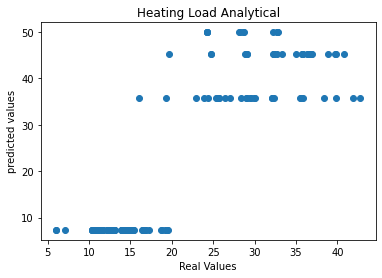

In [ ]:
features = df1.iloc[:,3].to_numpy()

mu=np.linspace(0,10,768)

phi_4= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_4[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,3]
X_train = phi_4[:614,:3]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



73.10726459446403


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

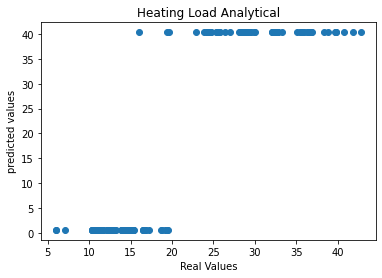

In [ ]:
features = df1.iloc[:,4].to_numpy()

mu=np.linspace(0,10,768)

phi_5= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_5[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,4]
X_train = phi_5[:614,:4]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



49.66437445877914


<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


Text(0.5, 1.0, 'Heating Load Analytical')

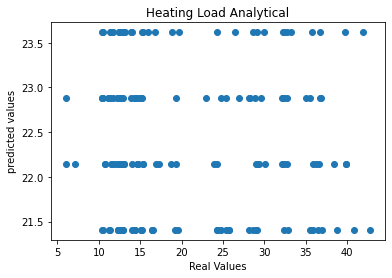

In [ ]:
features = df1.iloc[:,5].to_numpy()

mu=np.linspace(0,10,768)

phi_6= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_6[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,5]
X_train = phi_6[:614,:5]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


55.0988608735188


Text(0.5, 1.0, 'Heating Load Analytical')

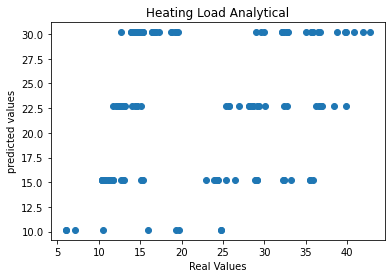

In [ ]:
features = df1.iloc[:,6].to_numpy()

mu=np.linspace(0,10,768)

phi_7= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_7[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,6]
X_train = phi_7[:614,:6]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



<ipython-input-5-03d4d870d2ae>:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, None]


48.615875629765675


Text(0.5, 1.0, 'Heating Load Analytical')

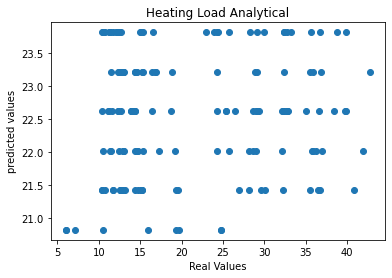

In [ ]:
features = df1.iloc[:,7].to_numpy()

mu=np.linspace(0,10,768)

phi_8= np.ones((features.shape[0], 1))

for i in range(features.shape[0]):
    phi_8[i] *= sigmoid(features[i], mu[i],1)

model = LinearRegression(1)
Y_true_heat = df1.iloc[614:,8]
X_test = df1.iloc[614:,7]
X_train = phi_8[:614,:7]
Y_train_heat = df1.iloc[:614,8]
yh_heat = model.fit_analytical(X_train,Y_train_heat).predict(X_test)
print(model.mse(Y_true_heat,yh_heat))

plt.scatter(Y_true_heat,yh_heat)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.title("Heating Load Analytical")



## Linear Regression: Analytical, Mini-Batch Stochastic Gradient Descent, Fully Batched Gradient Descent and ADAM Gradient Descent

4.260183579864162
27.724739689722373
3.466543803905717
3.387759443285912


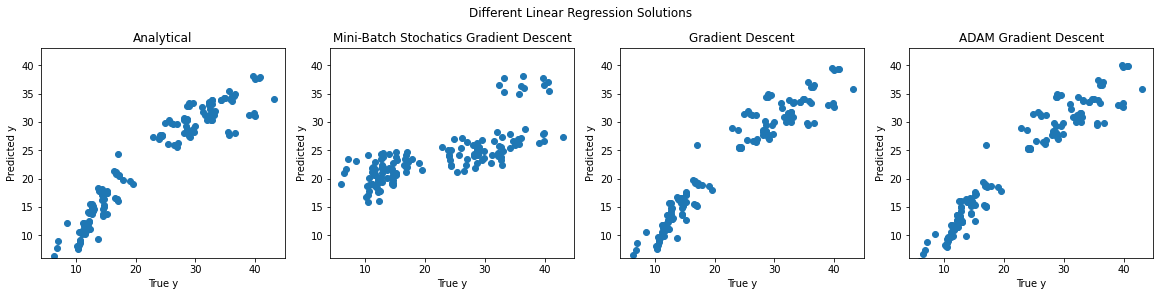

In [ ]:
# Split into training and test set (80/20)
x_df1_train, x_df1_test, y_df1_train, y_df1_test = train_test_split(x_df1, y_df1, test_size=0.2, random_state=10)

lin_model = LinearRegression(n_feats_df1, n_tgts_df1)
minib_sgd_optimizer = MiniBatchSGD(learning_rate=0.4)
adam_gd_optimizer = ADAM_GradientDescent()
gd_optimizer = GradientDescent()


# Analytical
yh_analytical = lin_model.fit_analytical(x_df1_train, y_df1_train.iloc[:, 0]).predict(x_df1_test)
print(LinearRegression.mse(y_df1_test.iloc[:, 0], yh_analytical))
yh_analytical = pd.Series(yh_analytical)


# Mini-Batch SGD
yh_mbsgd = lin_model.fit_gd(x_df1_train, y_df1_train.iloc[:, 0], minib_sgd_optimizer).predict(x_df1_test)
print(LinearRegression.mse(y_df1_test.iloc[:, 0], yh_mbsgd))
yh_mbsgd = pd.Series(yh_mbsgd)


# GD
yh_gd = lin_model.fit_gd(x_df1_train, y_df1_train.iloc[:, 0], gd_optimizer).predict(x_df1_test)
print(LinearRegression.mse(y_df1_test.iloc[:, 0], yh_gd))
yh_gd = pd.Series(yh_gd)


# GD with ADAM
yh_adamgd = lin_model.fit_gd(x_df1_train, y_df1_train.iloc[:, 0], adam_gd_optimizer).predict(x_df1_test)
print(LinearRegression.mse(y_df1_test.iloc[:, 0], yh_adamgd))
yh_adamgd = pd.Series(yh_adamgd)

fig, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(16, 4))
fig.suptitle('Different Linear Regression Solutions')
axes[0].scatter(y_df1_test.iloc[:, 0], yh_analytical)
axes[0].set_ylim([np.min(y_df1_test.iloc[:, 0]), np.max(y_df1_test.iloc[:, 0])])
axes[1].scatter(y_df1_test.iloc[:, 0], yh_mbsgd)
axes[1].set_ylim([np.min(y_df1_test.iloc[:, 0]), np.max(y_df1_test.iloc[:, 0])])
axes[2].scatter(y_df1_test.iloc[:, 0], yh_gd)
axes[2].set_ylim([np.min(y_df1_test.iloc[:, 0]), np.max(y_df1_test.iloc[:, 0])])
axes[3].scatter(y_df1_test.iloc[:, 0], yh_adamgd)
axes[3].set_ylim([np.min(y_df1_test.iloc[:, 0]), np.max(y_df1_test.iloc[:, 0])])
axes[0].set_title('Analytical')
axes[0].set_xlabel('True y')
axes[0].set_ylabel('Predicted y')
axes[1].set_title('Mini-Batch Stochatics Gradient Descent')
axes[1].set_xlabel('True y')
axes[1].set_ylabel('Predicted y')
axes[2].set_title('Gradient Descent')
axes[2].set_xlabel('True y')
axes[2].set_ylabel('Predicted y')
axes[3].set_title('ADAM Gradient Descent')
axes[3].set_xlabel('True y')
axes[3].set_ylabel('Predicted y')
plt.show()